In [1]:
import cv2
import numpy as np
import onnxruntime as rt
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
from rasterio.features import shapes
from shapely.geometry import shape, box
import pandas as pd
import geopandas as gpd
from glob import glob
import os
import json
from tqdm.contrib.concurrent import thread_map
plt.rcParams["figure.figsize"] = (10, 10)

images = sorted(glob("/mnt/raw_mosaics_and_lines/Uncertainty/Accuracy tests/Test1/Imagery/*.tif"))
vectors = sorted(glob("/mnt/raw_mosaics_and_lines/Uncertainty/Accuracy tests/Test1/Vectors/*.shp"))
print(f"{len(images)} tifs, {len(vectors)} shapefiles")

5 tifs, 60 shapefiles


In [2]:
def read_file(f):
    df = gpd.read_file(f)
    df["filename"] = os.path.splitext(os.path.basename(f))[0]
    return df

df = pd.concat(thread_map(read_file, vectors))
df["digitiser"] = df.filename.str[:2]
df

  0%|          | 0/60 [00:00<?, ?it/s]

Id                                           geometry  filename digitiser
0    0  LINESTRING (1609757.666 6100787.401, 1609716.9...       ER1        ER
1    0  LINESTRING (1609417.431 6101424.281, 1609368.6...       ER1        ER
2    0  LINESTRING (1608555.020 6102257.323, 1608541.5...       ER1        ER
3    0  LINESTRING (1589554.873 6163786.711, 1589519.9...       ER1        ER
4    0  LINESTRING (1732461.146 6067397.036, 1732453.4...       ER1        ER
..  ..                                                ...       ...       ...
1    0  LINESTRING (1732465.028 6067394.593, 1732463.4...  MT1Copy7        MT
0    0  LINESTRING (1728328.383 6077118.329, 1728333.1...  MT1Copy8        MT
1    0  LINESTRING (1732465.557 6067394.329, 1732462.9...  MT1Copy8        MT
0    0  LINESTRING (1728328.979 6077119.335, 1728332.9...  MT1Copy9        MT
1    0  LINESTRING (1732465.292 6067393.800, 1732462.6...  MT1Copy9        MT

[304 rows x 4 columns]

Northland_40cm_site1.tif


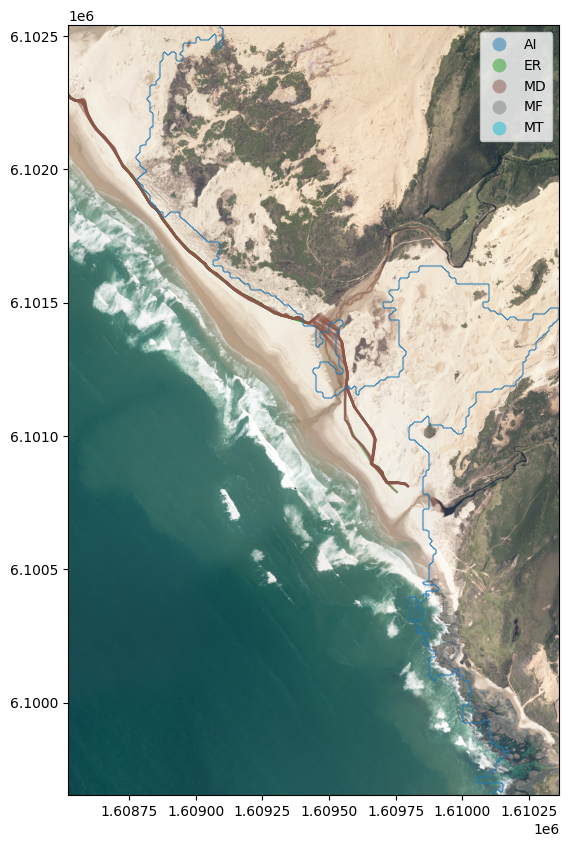

Northland_40cm_site2.tif


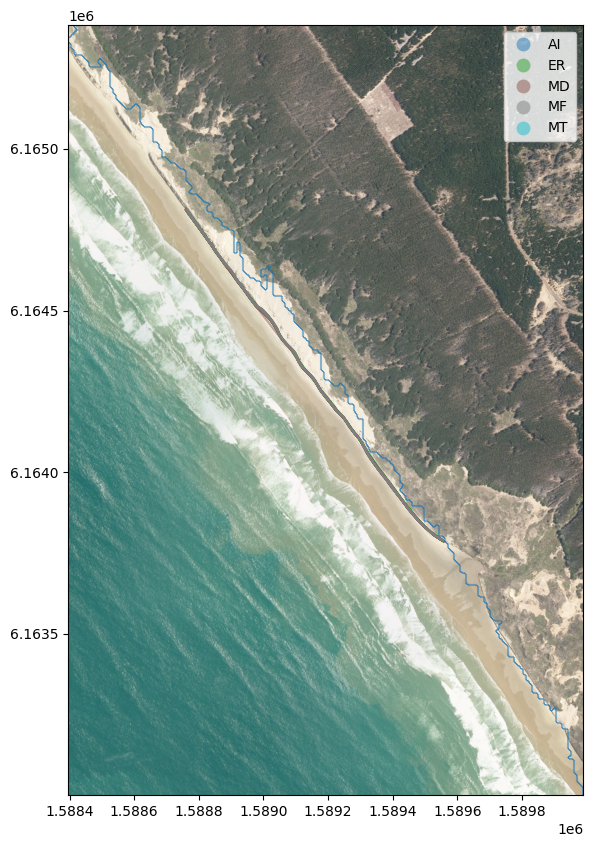

Northland_40cm_site3.tif


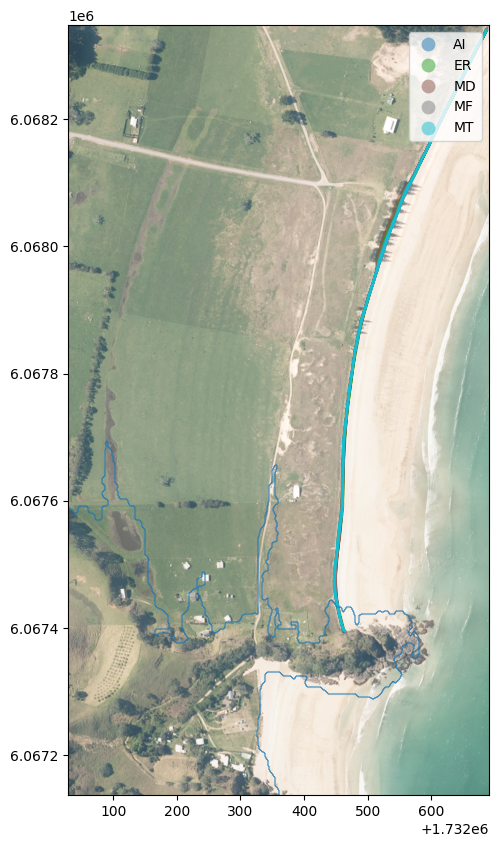

Northland_40cm_site4.tif


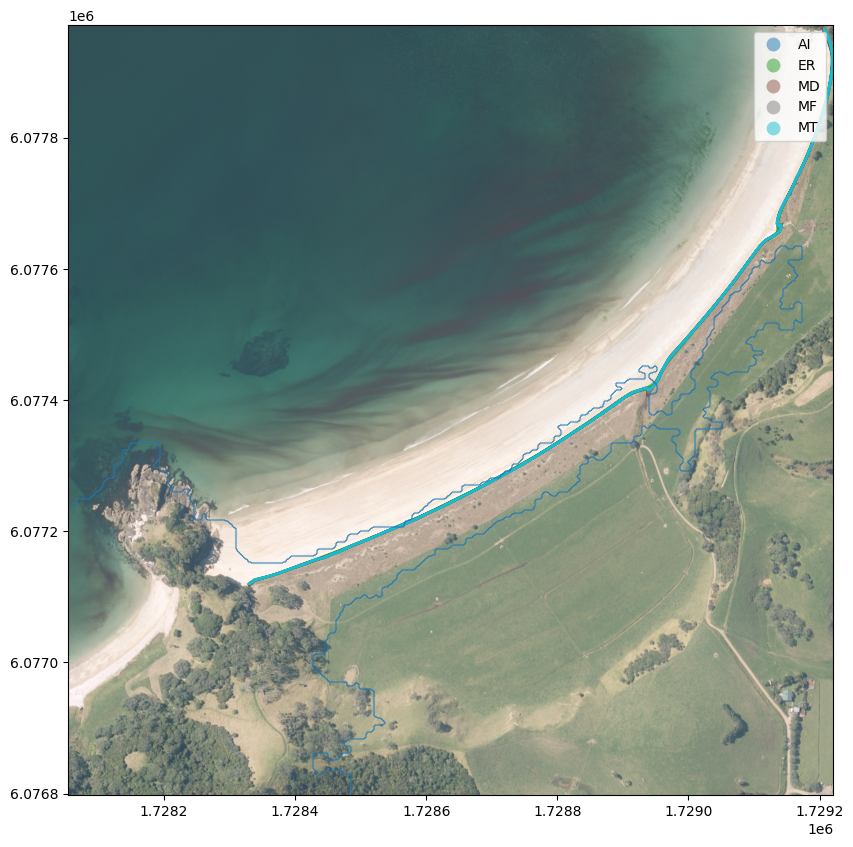

Northland_40cm_site5.tif


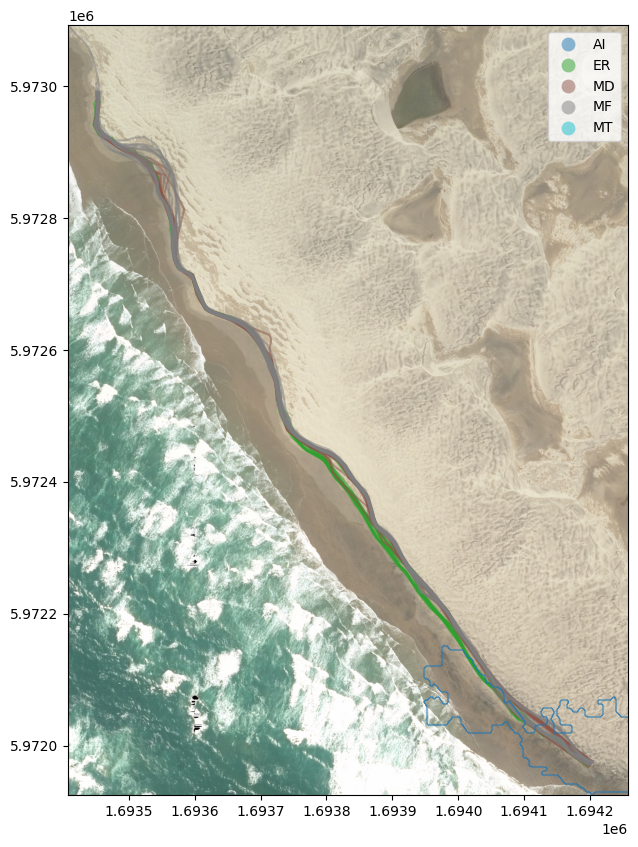

In [3]:
def predict(inp_image):

    model_path = '/mnt/output/land_bodies_model_long.onnx'
    inp_dim = inp_image.shape[:2]

    image_resized = cv2.resize(inp_image, (256, 256))
    image_resized = np.array(image_resized, dtype=np.float32) / 255.0
    image_resized = np.transpose(image_resized, (2, 0, 1))
    image_resized = np.expand_dims(image_resized, axis=0)

    session = rt.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name

    pred_onx = session.run([output_name], {input_name: image_resized.astype(np.float32)})[0]
    pred_onx = pred_onx > 0.5
    pred_onx = pred_onx * 255
    pred_onx = cv2.resize(pred_onx[0, 0].astype(np.uint8) , (inp_dim[1], inp_dim[0]))
    return pred_onx

for image_filename in images:
    print(os.path.basename(image_filename))
    image = rasterio.open(image_filename)
    # Read the image data as a numpy array
    image_data = rasterio.plot.reshape_as_image(image.read())

    mask = predict(image_data) / 255
    blur = cv2.GaussianBlur(mask, (15,15), sigmaX=15)
    blur = blur.round()

    # Vectorise raster
    shape_gen = ((shape(s), v) for s, v in shapes(blur.astype(np.uint8), transform=image.transform))
    # Convert shapes to GeoDataFrame, taking CRS from the image
    shape_df = gpd.GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen))), crs=image.crs)
    # Sort by area descending
    shape_df["area"] = shape_df.area
    shape_df.sort_values(by="area", inplace=True, ascending=False)
    # Take the largest land and the largest sea polygons
    land_poly = shape_df.geometry[shape_df["class"] == 1].iloc[0]
    sea_poly = shape_df.geometry[shape_df["class"] == 0].iloc[0]
    # Return the intersection thereof (EOV)
    line = land_poly.intersection(sea_poly)
    line_df = gpd.GeoDataFrame({"digitiser": ["AI"]}, geometry=[line], crs=df.crs)
    concat_df = pd.concat([df, line_df])
    fig, ax = plt.subplots()
    rasterio.plot.show(image.read(), ax=ax, transform=image.transform)
    concat_df.plot(column="digitiser", ax=ax, legend=True, alpha=.5)

    #b = image.bounds
    b = concat_df[concat_df.within(box(*list(image.bounds)))].total_bounds
    xlim = ([b[0], b[2]])
    ylim = ([b[1], b[3]])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()